Initial shape: (18468, 18)
Initial columns: ['video_id', 'video_published_timestamp', 'channel_id', 'channel_name', 'creator_type_id', 'video_length', 'views_final', 'impressions_final', 'like_final', 'comment_final', 'views3s_1k', 'impressions_1k', 'like_1k', 'comments_1k', 'views3s_5k', 'impressions_5k', 'like_5k', 'comments_5k']


/var/folders/db/wvxvqb3n1x3g3lw6rkhn8zxh0000gn/T/ipykernel_76539/2314333743.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')


After dropping final metrics, columns are: ['video_id', 'channel_id', 'channel_name', 'creator_type_id', 'video_length', 'views_final', 'views3s_1k', 'impressions_1k', 'like_1k', 'comments_1k', 'views3s_5k', 'impressions_5k', 'like_5k', 'comments_5k']
Lifetime class distribution:
lifetime_class
1    8288
2    8285
0    1895
Name: count, dtype: int64
Dropping non-numeric column 'channel_name'
Dropping non-numeric column 'creator_type_id'
Final feature columns: ['channel_id', 'video_length', 'views3s_1k', 'impressions_1k', 'like_1k', 'comments_1k', 'views3s_5k', 'impressions_5k', 'like_5k', 'comments_5k']
LC=2, best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
LC=1, best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
LC=0, best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.wa


Test MAPE (original scale): 1.7442 (i.e. 174.42%)
Test R^2  (original scale): 0.0486


/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.wa

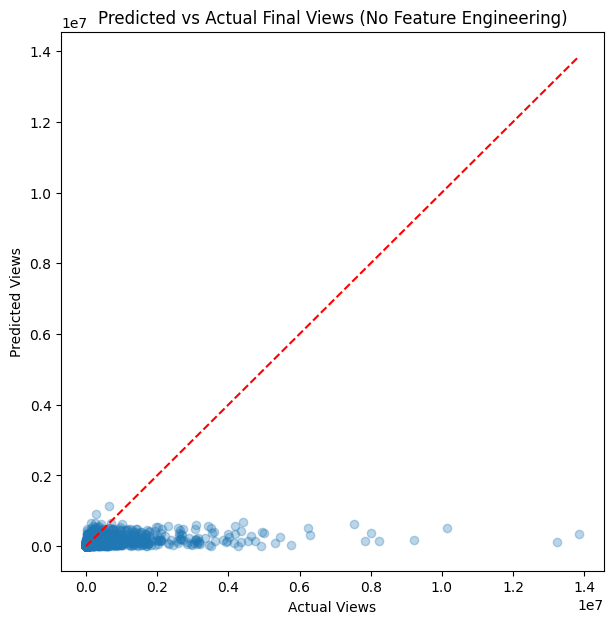

In [3]:
###############################################################################
# SINGLE-CELL NOTEBOOK EXAMPLE: LARM-LIKE APPROACH WITH "NO FEATURE ENGINEERING"
# -----------------------------------------------------------------------------
# This code:
#   - Loads your data
#   - Drops or parses the timestamp
#   - Drops *_final columns except "views_final" (our target)
#   - Creates a minimal lifetime_class from raw columns (no derived CTR, etc.)
#   - Log-transforms "views_final" (to handle skew)
#   - Trains specialized regressors and a fallback
#   - Evaluates predictions on the original scale
###############################################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# 1) LOAD DATA
df = pd.read_csv("../data/Initial Engagement v1 - _WITH_videos_AS_get_the_videos_.csv")  # <-- Adjust path as needed
print("Initial shape:", df.shape)
print("Initial columns:", df.columns.tolist())

# 2) HANDLE TIMESTAMP (IF ANY)
timestamp_col = "video_published_timestamp"
if timestamp_col in df.columns:
    # Try parsing to datetime
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
    # If you want to keep the numeric features from the date, you can do so:
    # df["publish_hour"] = df[timestamp_col].dt.hour
    # df["publish_weekday"] = df[timestamp_col].dt.weekday
    # df["publish_dayofyear"] = df[timestamp_col].dt.dayofyear
    # For "no feature engineering," we'll just drop the original timestamp
    df.drop(timestamp_col, axis=1, inplace=True)

# 3) DROP *_final COLUMNS EXCEPT 'views_final'
cols_to_drop = []
for col in df.columns:
    if col.endswith("_final") and col != "views_final":
        cols_to_drop.append(col)
if cols_to_drop:
    df.drop(columns=cols_to_drop, inplace=True)

print("After dropping final metrics, columns are:", df.columns.tolist())

# 4) MINIMAL LIFETIME CLASS (NO EXTRA ENGINEERING)
# ----------------------------------------------------------------------------
# We'll define "lifetime_class" purely from an existing raw column, say "views3s_5k".
# If the video never reached 5k 3s-views (==0 or missing), we label it class 0,
# otherwise, we bin them into (1, 2) via median. This is extremely minimal, but
# it still keeps the LARM "specialized" idea in a trivial form.

df["lifetime_class"] = 0

# Mark videos that have any nonzero 5k data
mask_5k = (df.get("views3s_5k", 0) > 0)
df_5k = df.loc[mask_5k].copy()

if len(df_5k) > 0:
    # We do a 2-bin split on "views3s_5k" (just as an example).
    # You can do more bins, e.g. q=3 or q=4, but let's keep it minimal.
    df_5k["lifetime_class"] = pd.qcut(df_5k["views3s_5k"], q=2, labels=[1,2]).astype(int)
    df.loc[mask_5k, "lifetime_class"] = df_5k["lifetime_class"]

print("Lifetime class distribution:")
print(df["lifetime_class"].value_counts())

# 5) LOG-TRANSFORM THE TARGET
target_col = "views_final"
if target_col not in df.columns:
    raise ValueError("No 'views_final' column found in data.")

df["views_final_log"] = np.log1p(df[target_col])  # log(1 + views_final)

# 6) PREPARE NUMERIC DATA
excluded = ["video_id", "lifetime_class", target_col, "views_final_log"]
feature_cols = [c for c in df.columns if c not in excluded]

# Drop rows where the target column contains NaN
df = df.dropna(subset=["views_final_log"])

X_full = df[feature_cols].copy()
y_full = df["views_final_log"]
lc_full = df["lifetime_class"]

# Drop or convert non-numeric columns
for col in X_full.columns:
    if X_full[col].dtype == "object":
        print(f"Dropping non-numeric column '{col}'")
        X_full.drop(col, axis=1, inplace=True)

# Fill any leftover NaN
X_full = X_full.fillna(0)

print("Final feature columns:", X_full.columns.tolist())

# 7) TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test, lc_train, lc_test = train_test_split(
    X_full, y_full, lc_full, test_size=0.2, random_state=42
)

# 8) SPECIALIZED MODELS VIA LIFETIME CLASS
#    We'll do a simple GridSearch for each class.
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

specialized_models = {}
unique_lcs = lc_train.unique()

for lc in unique_lcs:
    mask = (lc_train == lc)
    if mask.sum() < 5:
        # If too few samples in that class, skip big search
        gb = GradientBoostingRegressor(random_state=42)
        gb.fit(X_train[mask], y_train[mask])
        specialized_models[lc] = gb
        continue

    base_gb = GradientBoostingRegressor(random_state=42)
    gs = GridSearchCV(
        estimator=base_gb,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        scoring='neg_mean_absolute_percentage_error'
    )
    gs.fit(X_train[mask], y_train[mask])
    specialized_models[lc] = gs.best_estimator_
    print(f"LC={lc}, best params: {gs.best_params_}")

# Fallback model
fallback_gb = GradientBoostingRegressor(random_state=42)
fallback_gb.fit(X_train, y_train)
specialized_models["fallback"] = fallback_gb

# 9) PREDICT ON TEST (INVERSE LOG)
y_pred_log = np.zeros(len(X_test))

for i, idx in enumerate(X_test.index):
    c = lc_test.loc[idx]
    model = specialized_models[c] if c in specialized_models else specialized_models["fallback"]
    row_feats = X_test.loc[idx].values.reshape(1, -1)
    y_pred_log[i] = model.predict(row_feats)[0]

y_pred = np.expm1(y_pred_log)            # inverse log transform
y_test_exp = np.expm1(y_test.values)     # actual on original scale

# 10) EVALUATE
mape = mean_absolute_percentage_error(y_test_exp, y_pred)
r2 = r2_score(y_test_exp, y_pred)
print(f"\nTest MAPE (original scale): {mape:.4f} (i.e. {mape*100:.2f}%)")
print(f"Test R^2  (original scale): {r2:.4f}")

plt.figure(figsize=(7,7))
plt.scatter(y_test_exp, y_pred, alpha=0.3)
plt.plot([y_test_exp.min(), y_test_exp.max()],[y_test_exp.min(), y_test_exp.max()], 'r--')
plt.title("Predicted vs Actual Final Views (No Feature Engineering)")
plt.xlabel("Actual Views")
plt.ylabel("Predicted Views")
plt.show()